In [2]:
from modules.corr_graficas import *

c:\Users\hgera\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


c:\Users\hgera\OneDrive\Escritorio\GITHUB\Air-Quality-Mex\modules\corr_graficas.py:76: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Coeficiente de correlación de Pearson: 0.68
R² (coeficiente de determinación): 0.47
p-valor: 0.0428


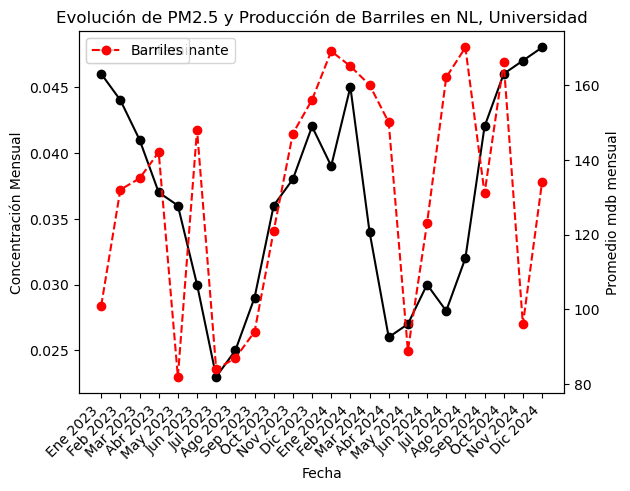

In [6]:
main(archivo_pkl = 'data\IndicedeCalidad\data_NO2.pkl', estacion = 'NL, Universidad', iloc_inicio= 7 , iloc_fin=16  )

### Hagamos una gráfica dinamica y agreguemos las distancias en km para las estaciones

In [ ]:
import pandas as pd
coor = pd.read_csv(r'data/Estaciones_coordenadas.csv')
coor

,Estacion,lat,long,Distancia_km
0,Cadereyta,25.60,-99.99,4.9
1,Juarez,25.65,-100.10,17.2
2,Pesquería,25.79,-100.08,26.4
3,Pueblo Serena,25.58,-100.25,30.7
4,La Pastora,25.67,-100.25,32.1
5,Apodaca,25.78,-100.19,32.7
6,San Nicolás,25.75,-100.26,36.5
7,Universidad,25.73,-100.31,40.0
8,Obispado,25.68,-100.34,41.0
9,Escobedo,25.80,-100.34,46.2


In [25]:
import pickle as pkl
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr

# Traducción de meses
meses_es = {
    'January': 'Enero', 'February': 'Febrero', 'March': 'Marzo', 'April': 'Abril',
    'May': 'Mayo', 'June': 'Junio', 'July': 'Julio', 'August': 'Agosto',
    'September': 'Septiembre', 'October': 'Octubre', 'November': 'Noviembre', 'December': 'Diciembre'
}

# Coordenadas de estaciones con distancia en km
estaciones_km = {
    'NL, Cadereyta': 4.9,
    'NL, Juarez': 17.2,
    'NL, Universidad': 40.0
}

# Umbrales de calidad del aire para PM2.5 y PM10
umbrales = {
    'PM2.5': [(15, 'Buena', 'rgb(0,228,0)'), (33, 'Aceptable', 'rgb(255,255,0)'), 
              (79, 'Mala', 'rgb(255,126,0)'), (130, 'Muy mala', 'rgb(255,0,0)'), 
              (200, 'Extremadamente mala', 'rgb(143,63,151)')],
    'PM10': [(45, 'Buena', 'rgb(0,228,0)'), (60, 'Aceptable', 'rgb(255,255,0)'), 
             (132, 'Mala', 'rgb(255,126,0)'), (213, 'Muy mala', 'rgb(255,0,0)'), 
             (300, 'Extremadamente mala', 'rgb(143,63,151)')]
}

# Función para cargar datos de PM2.5 o PM10
def cargar_datos(archivo_pkl, estacion):
    with open(archivo_pkl, 'rb') as f:
        data = pkl.load(f)
    pm_NL = data.query(f'Estación == "{estacion}"')
    m_pm_NL = pm_NL.groupby(pm_NL['Fecha_Dia'].dt.to_period("M"))['Concentración por día'].mean().reset_index()
    m_pm_NL.rename(columns={'Fecha_Dia': 'Fecha', 'Concentración por día': 'Concentración Promedio Mensual'}, inplace=True)
    m_pm_NL['Concentración Promedio Mensual'] = m_pm_NL['Concentración Promedio Mensual'].round(2)
    return m_pm_NL

# Rango de datos
iloc_inicio = 0
iloc_fin = 24

# Archivos de datos
archivo_pm25 = 'data/IndicedeCalidad/data_PM2.5.pkl'
archivo_pm10 = 'data/IndicedeCalidad/data_PM10.pkl'
estaciones = list(estaciones_km.keys())

# Datos de producción de barriles
pemex_NL = pd.DataFrame({
    'Fecha': pd.date_range(start='2023-01', end='2025-01', freq='M').strftime('%Y-%B'),
    'Miles de barriles mensuales': [101, 132, 135, 142, 82, 148, 84, 87, 94, 121, 147, 156,
                                    169, 165, 160, 150, 89, 123, 162, 170, 131, 166, 96, 134]
})

# Reemplazar nombres de meses en inglés por español
pemex_NL['Fecha'] = pemex_NL['Fecha'].replace(meses_es, regex=True)

# Crear gráfico con doble eje Y
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Agregar producción de barriles al eje derecho
fig.add_trace(go.Scatter(x=pemex_NL['Fecha'][iloc_inicio:iloc_fin], 
                         y=pemex_NL['Miles de barriles mensuales'][iloc_inicio:iloc_fin], 
                         mode='lines+markers', 
                         name='Refinería Ing. Héctor R. Lara Sosa', 
                         line=dict(color='black', width=2), 
                         marker=dict(symbol='circle', size=6)), 
              secondary_y=True)

# Agregar datos de PM2.5 y PM10 por estación
for estacion in estaciones:
    m_pm25_NL = cargar_datos(archivo_pm25, estacion)
    m_pm10_NL = cargar_datos(archivo_pm10, estacion)
    
    barriles = pemex_NL['Miles de barriles mensuales'].iloc[iloc_inicio:iloc_fin]
    pm25 = m_pm25_NL['Concentración Promedio Mensual'].iloc[iloc_inicio:iloc_fin]
    pm10 = m_pm10_NL['Concentración Promedio Mensual'].iloc[iloc_inicio:iloc_fin]
    
    # Cálculo de correlación
    corr_pm25, _ = pearsonr(barriles.dropna(), pm25.dropna())
    corr_pm10, _ = pearsonr(barriles.dropna(), pm10.dropna())

    # Agregar puntos de datos de PM2.5 con label de kilómetros
    fig.add_trace(go.Scatter(
        x=pemex_NL['Fecha'][iloc_inicio:iloc_fin], 
        y=pm25, 
        mode='markers+lines', 
        name=f'PM2.5 {estacion} ({estaciones_km[estacion]} km)', 
        marker=dict(size=8)), 
        secondary_y=False)
    
    # Agregar puntos de datos de PM10 con label de kilómetros
    fig.add_trace(go.Scatter(
        x=pemex_NL['Fecha'][iloc_inicio:iloc_fin], 
        y=pm10, 
        mode='markers+lines', 
        name=f'PM10 {estacion} ({estaciones_km[estacion]} km)', 
        marker=dict(size=8, symbol="triangle-up")), 
        secondary_y=False)
    
    print(f'[{estacion} - {estaciones_km[estacion]} km] PM2.5 - Correlación con barriles: {corr_pm25:.2f}')
    print(f'[{estacion} - {estaciones_km[estacion]} km] PM10 - Correlación con barriles: {corr_pm10:.2f}')

# Agregar líneas horizontales de umbrales
for contaminante, niveles in umbrales.items():
    if contaminante == 'PM2.5':
        estilo = "solid"
    else:
        estilo = 'dot'
    for valor, label, color in niveles:
     
        fig.add_trace(
            go.Scatter(
                x=[pemex_NL['Fecha'].iloc[iloc_inicio], pemex_NL['Fecha'].iloc[iloc_fin-1]],
                y=[valor, valor],
                mode='lines',
                line=dict(color=color, width=2, dash=estilo),
                name=f'{label} ({contaminante})',
                showlegend=True,
                visible= 'legendonly'
            )
        )
        
        # fig.add_annotation(
        #     x=pemex_NL['Fecha'].iloc[0], y=valor,
        #     text=f"{label} ({contaminante})",
        #     showarrow=False,
        #     font=dict(color='black', size=7),
        #     xanchor="left",
        #     yanchor= 'top'
        # )

# Configurar ejes
fig.update_layout(
    title="Red: Monterrey",
    xaxis_title="Fecha",
    yaxis_title=r'Promedio mensual concentración 24h [µg/m³]',
    yaxis2_title="Promedio mensual [mbd]",
    legend=dict(x=1, y=1),
    template="plotly_white"
)
fig.update_layout(xaxis=dict(tickangle=-45))  # Rotar etiquetas del eje X 45 grados
fig.write_html('Barriles_vs_PM.html')

# Mostrar gráfico
fig.show()


[NL, Cadereyta - 4.9 km] PM2.5 - Correlación con barriles: 0.08
[NL, Cadereyta - 4.9 km] PM10 - Correlación con barriles: -0.07
[NL, Juarez - 17.2 km] PM2.5 - Correlación con barriles: 0.04
[NL, Juarez - 17.2 km] PM10 - Correlación con barriles: 0.11
[NL, Universidad - 40.0 km] PM2.5 - Correlación con barriles: 0.14
[NL, Universidad - 40.0 km] PM10 - Correlación con barriles: 0.12


C:\Users\hgera\AppData\Local\Temp\ipykernel_16748\4036649504.py:52: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



#### Para no PM

In [31]:
import pickle as pkl
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr

# Traducción de meses
meses_es = {
    'January': 'Enero', 'February': 'Febrero', 'March': 'Marzo', 'April': 'Abril',
    'May': 'Mayo', 'June': 'Junio', 'July': 'Julio', 'August': 'Agosto',
    'September': 'Septiembre', 'October': 'Octubre', 'November': 'Noviembre', 'December': 'Diciembre'
}

# Coordenadas de estaciones con distancia en km
estaciones_km = {
    'NL, Cadereyta': 4.9,
    'NL, Juarez': 17.2,
    'NL, Universidad': 40.0
}

# Umbrales de calidad del aire
umbrales = {
    'NO2': [(0.053, 'Buena', 'rgb(0,228,0)'), (0.106, 'Aceptable', 'rgb(255,255,0)'), 
            (0.160, 'Mala', 'rgb(255,126,0)'), (0.213, 'Muy mala', 'rgb(255,0,0)'), 
            (float('inf'), 'Extremadamente mala', 'rgb(143,63,151)')],
    'O3': [(0.058, 'Buena', 'rgb(0,228,0)'), (0.090, 'Aceptable', 'rgb(255,255,0)'), 
           (0.135, 'Mala', 'rgb(255,126,0)'), (0.175, 'Muy mala', 'rgb(255,0,0)'), 
           (float('inf'), 'Extremadamente mala', 'rgb(143,63,151)')],
    'SO2': [(0.035, 'Buena', 'rgb(0,228,0)'), (0.075, 'Aceptable', 'rgb(255,255,0)'), 
            (0.185, 'Mala', 'rgb(255,126,0)'), (0.304, 'Muy mala', 'rgb(255,0,0)'), 
            (float('inf'), 'Extremadamente mala', 'rgb(143,63,151)')],
    
}

# Función para cargar datos de NO2, O3 y SO2
def cargar_datos(archivo_pkl, estacion):
    with open(archivo_pkl, 'rb') as f:
        data = pkl.load(f)
    pm_NL = data.query(f'Estación == "{estacion}"')
    m_pm_NL = pm_NL.groupby(pm_NL['Fecha'].dt.to_period("M"))['Concentración por día'].mean().reset_index()
    m_pm_NL.rename(columns={'Fecha_Dia': 'Fecha', 'Concentración por día': 'Concentración Promedio Mensual'}, inplace=True)
    m_pm_NL['Concentración Promedio Mensual'] = m_pm_NL['Concentración Promedio Mensual'].round(3)
    return m_pm_NL

# Rango de datos
iloc_inicio = 0
iloc_fin = 24

# Archivos de datos
archivo_NO2 = 'data/IndicedeCalidad/data_NO2.pkl'
archivo_O3 = 'data/IndicedeCalidad/data_O3.pkl'
archivo_SO2 = 'data/IndicedeCalidad/data_SO2.pkl'
estaciones = list(estaciones_km.keys())

# Datos de producción de barriles
pemex_NL = pd.DataFrame({
    'Fecha': pd.date_range(start='2023-01', end='2025-01', freq='M').strftime('%Y-%B'),
    'Miles de barriles mensuales': [101, 132, 135, 142, 82, 148, 84, 87, 94, 121, 147, 156,
                                    169, 165, 160, 150, 89, 123, 162, 170, 131, 166, 96, 134]
})

# Reemplazar nombres de meses en inglés por español
pemex_NL['Fecha'] = pemex_NL['Fecha'].replace(meses_es, regex=True)

# # Reemplazar Period por timestamp para las fechas
# pemex_NL['Fecha'] = pd.to_datetime(pemex_NL['Fecha'].to_list())



# Crear gráfico con doble eje Y
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Agregar producción de barriles al eje derecho
fig.add_trace(go.Scatter(x=pemex_NL['Fecha'][iloc_inicio:iloc_fin], 
                         y=pemex_NL['Miles de barriles mensuales'][iloc_inicio:iloc_fin], 
                         mode='lines+markers', 
                         name='Refinería Ing. Héctor R. Lara Sosa', 
                         line=dict(color='black', width=2), 
                         marker=dict(symbol='circle', size=6)), 
              secondary_y=True)
# Agregar datos de NO2, O3 y SO2 por estación
for estacion in estaciones:
    m_NO2_NL = cargar_datos(archivo_NO2, estacion)
    m_O3_NL = cargar_datos(archivo_O3, estacion)
    m_SO2_NL = cargar_datos(archivo_SO2, estacion)
    
        # Si las fechas son Period, convertirlas a Timestamp usando to_timestamp()
    if isinstance(m_NO2_NL['Fecha'].iloc[0], pd.Period):
        m_NO2_NL['Fecha'] = m_NO2_NL['Fecha'].apply(lambda x: x.to_timestamp())
    if isinstance(m_O3_NL['Fecha'].iloc[0], pd.Period):
        m_O3_NL['Fecha'] = m_O3_NL['Fecha'].apply(lambda x: x.to_timestamp())
    if isinstance(m_SO2_NL['Fecha'].iloc[0], pd.Period):
        m_SO2_NL['Fecha'] = m_SO2_NL['Fecha'].apply(lambda x: x.to_timestamp())

    # Ahora las fechas deberían estar en formato datetime
    m_NO2_NL['Fecha'] = pd.to_datetime(m_NO2_NL['Fecha'])
    m_O3_NL['Fecha'] = pd.to_datetime(m_O3_NL['Fecha'])
    m_SO2_NL['Fecha'] = pd.to_datetime(m_SO2_NL['Fecha'])
    
    
    barriles = pemex_NL['Miles de barriles mensuales'].iloc[iloc_inicio:iloc_fin]
    NO2 = m_NO2_NL['Concentración Promedio Mensual'].iloc[iloc_inicio:iloc_fin]
    O3 = m_O3_NL['Concentración Promedio Mensual'].iloc[iloc_inicio:iloc_fin]
    SO2 = m_SO2_NL['Concentración Promedio Mensual'].iloc[iloc_inicio:iloc_fin]
    
    # Cálculo de correlación
    corr_NO2, _ = pearsonr(barriles.dropna(), NO2.dropna())
    corr_O3, _ = pearsonr(barriles.dropna(), O3.dropna())
    corr_SO2, _ = pearsonr(barriles.dropna(), SO2.dropna())

    print(f'[{estacion} - {estaciones_km[estacion]} km] NO2 - Correlación con barriles: {corr_NO2:.2f}')
    print(f'[{estacion} - {estaciones_km[estacion]} km] O3 - Correlación con barriles: {corr_O3:.2f}')
    print(f'[{estacion} - {estaciones_km[estacion]} km] SO2 - Correlación con barriles: {corr_SO2:.2f}')
    
    # Agregar trazas de calidad del aire
    fig.add_trace(go.Scatter(x=pemex_NL['Fecha'][iloc_inicio:iloc_fin], 
                             y=NO2, 
                             mode='lines+markers', 
                             name=f'NO2 {estacion} ({estaciones_km[estacion]} km)', 
                             line=dict(width=2), 
                             marker=dict(size=8, symbol = "cross") ),
                            secondary_y=False)
    
    fig.add_trace(go.Scatter(x=pemex_NL['Fecha'][iloc_inicio:iloc_fin], 
                             y=O3, 
                             mode='lines+markers', 
                             name=f'O3 {estacion} ({estaciones_km[estacion]} km)', 
                             line=dict(width=2), marker = dict(size=8, symbol="square")),
                  
                  secondary_y=False)
    
    fig.add_trace(go.Scatter(x=pemex_NL['Fecha'][iloc_inicio:iloc_fin], 
                             y=SO2, 
                             mode='lines+markers', 
                             name=f'SO2 {estacion} ({estaciones_km[estacion]} km)', 
                             line=dict( width=2),  marker = dict(size=8, symbol="triangle-up")),
                 
                  secondary_y=False)


# Agregar líneas horizontales de umbrales
for contaminante, niveles in umbrales.items():
    if contaminante == 'PM2.5':
        estilo = "solid"
    else:
        estilo = 'dot'
    for valor, label, color in niveles:
     
        fig.add_trace(
            go.Scatter(
                x=[pemex_NL['Fecha'].iloc[iloc_inicio], pemex_NL['Fecha'].iloc[iloc_fin-1]],
                y=[valor, valor],
                mode='lines',
                line=dict(color=color, width=2, dash=estilo),
                name=f'{label} ({contaminante})',
                showlegend=True,
                visible='legendonly'
            )
        )
        
        # fig.add_annotation(
        #     x=pemex_NL['Fecha'].iloc[0], y=valor,
        #     text=f"{label} ({contaminante})",
        #     showarrow=False,
        #     font=dict(color='black', size=7),
        #     xanchor="left",
        #     yanchor= 'top'
        # )

# Configurar ejes
fig.update_layout(
    title="Red: Monterrey",
    xaxis_title="Fecha",
    yaxis_title=r'Promedio mensual concentración 24h [ppm]',
    yaxis2_title="Promedio mensual [mbd]",
    legend=dict(x=1, y=1),
    template="plotly_white"
)
fig.update_layout(xaxis=dict(tickangle=-45))  # Rotar etiquetas del eje X 45 grados
fig.write_html('Barriles_vs_NOPM.html')

# Mostrar gráfico
fig.show()


[NL, Cadereyta - 4.9 km] NO2 - Correlación con barriles: 0.20
[NL, Cadereyta - 4.9 km] O3 - Correlación con barriles: -0.11
[NL, Cadereyta - 4.9 km] SO2 - Correlación con barriles: -0.11
[NL, Juarez - 17.2 km] NO2 - Correlación con barriles: 0.10
[NL, Juarez - 17.2 km] O3 - Correlación con barriles: -0.47
[NL, Juarez - 17.2 km] SO2 - Correlación con barriles: -0.18
[NL, Universidad - 40.0 km] NO2 - Correlación con barriles: 0.25
[NL, Universidad - 40.0 km] O3 - Correlación con barriles: -0.31
[NL, Universidad - 40.0 km] SO2 - Correlación con barriles: -0.24


C:\Users\hgera\AppData\Local\Temp\ipykernel_16748\2522653519.py:57: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

